In [1]:
!pip install pyDOE

import scipy.io
import numpy as np
from pyDOE import lhs
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl
import matplotlib.pyplot as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18166 sha256=eeb1d4751dbec24f8283cb1ce6ecf1a5f3ba3f67b30b2bd29dd4f7176a59c00c
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE
TensorFlow version: 2.12.0


In [2]:
# External source sineburst excitation parameters
Lx = 0.3 # x-length of the steel plate[m]
c = 4773.343  # [m/s]
fex = 120000 # frequency in Hz used in excitation
Tex = 1/fex # time period of the excitation
cycles = 5
dt =  Tex/40 #in seconds
tsim = 1.2*Lx/2/c # total simulation time
#-------------------------------------------------------------------------------
# Damage model data for MATLAB
lb_input = np.array([0.0, 0.0, 0.0,0.0,0.0]) # (x_0,y_0,t_0)
lb_output = -5e-25
ub_input =  np.array([0.3,0.3,tsim,0.3,0.3])  # (x_n,y_n,t_n)
ub_output = 5e-25

# Load Data
data = scipy.io.loadmat('wave2d_damage.mat')
#damage_data = data['damage_data']
disp_data = data['saved_dis'] # 151 x 151 x 16
t_data = data['time_data'] # 1 x 16 [# done]
x_data = data['x'] # 1 x 151
y_data = data['y'] # 1 x 151
print('disp_data : ', np.shape(disp_data))
print('t_data : ', np.shape(t_data))
print('x_data : ', np.shape(x_data))
print('y_data : ', np.shape(y_data))


disp_data :  (151, 151, 16)
t_data :  (1, 16)
x_data :  (1, 151)
y_data :  (1, 151)


In [3]:
# Modifying shapes of input MATLAB data to be compatible for training

#---------------Space co-ordinates----------------------------------------------
x_data = x_data.T # 151 x 1
y_data = y_data.T # 151 x 1
X,Y = np.meshgrid(x_data,y_data)
X_Y_data = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
print('X_Y_data : ',np.shape(X_Y_data)) # 22801 x 2

#---------------Displacement field----------------------------------------------
disp_data = disp_data.reshape(-1,16)
print('disp_data : ',np.shape(disp_data))  # 22801 x 64

#-------------------------------------------------------------------------------
# Lets set equal shape for all input and output data
TT= np.tile(t_data,(22801, 1)) # repeats time_data row-wise
print('t_star : ',np.shape(TT))
XX= np.tile(X_Y_data[:,0:1],(1,16)) # repeats x_star column-wise
print('x_star : ',np.shape(XX))
YY= np.tile(X_Y_data[:,1:2],(1,16)) # repeats y_star column-wise
print('y_star : ',np.shape(YY))
UU = disp_data
print('u_star : ',np.shape(UU))

# Reshape input and outputs as column vector
print('After reshaping to column vectors : ')
t_star = np.reshape(TT,(-1,1))
print('t_star : ',np.shape(t_star))
x_star = np.reshape(XX,(-1,1))
print('x_star : ',np.shape(x_star))
y_star = np.reshape(YY,(-1,1))
print('y_star : ',np.shape(y_star))
u_star = np.reshape(UU,(-1,1))
print('u_star : ',np.shape(u_star))

#---------------Damage location parameters--------------------------------------
damage_x = np.zeros((151,1))
#damage_x[120] = 1
damage_x[0:151] = 0.12
#print(damage_x)

damage_y = np.zeros((151,1))
damage_y[0:151] = 0.19
#damage_y[120] = 1

Dx,Dy = np.meshgrid(damage_x,damage_y)
Dx_Dy_data = np.hstack((Dx.flatten()[:,None], Dy.flatten()[:,None]))
print('Dx_Dy_data : ',np.shape(Dx_Dy_data)) # 22801 x 2

dx_star = np.tile(Dx_Dy_data [:,0:1],(1,16)) # repeats d_star column-wise
print('dx_star : ',np.shape(dx_star))
dy_star = np.tile(Dx_Dy_data [:,1:2],(1,16)) # repeats d_star column-wise
print('dy_star : ',np.shape(dy_star))

dx_star = np.reshape(dx_star,(-1,1))
print('dx_star after reshaping : ',np.shape(dx_star))
dy_star = np.reshape(dy_star,(-1,1))
print('dy_star after reshaping : ',np.shape(dy_star))

"""**3.Training Data**"""

def trainingdata(N_u_ic, N_u_bc, N_f ,N_d):

  # Initial condition
  t_b0 = t_star[t_star==t_star.min()][:,None]
  x_b0 = x_star[t_star == t_star.min()][:,None]
  y_b0 = y_star[t_star == t_star.min()][:,None]
  dx_b0 = dx_star[t_star == t_star.min()][:,None]
  dy_b0 = dy_star[t_star == t_star.min()][:,None]
  X_b0 = np.concatenate([x_b0,y_b0,t_b0,dx_b0,dy_b0],1)  # concatenate  x_b0, y_b0,t_b0, dx_b0, dy_b0
  print('X_b0 : ', np.shape(X_b0))
  u_b0 = u_star[t_star == t_star.min()][:,None]
  print('t_b0 : ', np.shape(t_b0),'x_b0 : ', np.shape(x_b0),
        'y_b0 : ', np.shape(y_b0),'dx_b0 : ', np.shape(dx_b0),
        'dy_b0 : ', np.shape(dy_b0),'u_b0 : ', np.shape(u_b0) )


  # Boundary condition - left side <--- 151 x 16 = (left boubary space grid points x timesteps)
  t_b1 = t_star[x_star==x_star.min()][:,None]
  x_b1 = x_star[x_star == x_star.min()][:,None]
  y_b1 = y_star[x_star == x_star.min()][:,None]
  dx_b1 = dx_star[x_star == x_star.min()][:,None]
  dy_b1 = dy_star[x_star == x_star.min()][:,None]
  X_b1 = np.concatenate([x_b1,y_b1,t_b1,dx_b1,dy_b1],1)  # concatenate x_b1, y_b1, t_b1, dx_b1, dy_b1
  print('X_b1 : ', np.shape(X_b1))
  u_b1 = u_star[x_star == x_star.min()][:,None]
  print('t_b1 : ', np.shape(t_b1),'x_b1 : ', np.shape(x_b1),
        'y_b1 : ', np.shape(y_b1),'dx_b1 : ', np.shape(dx_b1),
        'dy_b1 : ', np.shape(dy_b1),'u_b1 : ', np.shape(u_b1))

  # Boundary condition - right side <--- 151 x 16 = (right boubary space grid points x timesteps)
  t_b2 = t_star[x_star==x_star.max()][:,None]
  x_b2 = x_star[x_star == x_star.max()][:,None]
  y_b2 = y_star[x_star == x_star.max()][:,None]
  dx_b2 = dx_star[x_star == x_star.max()][:,None]
  dy_b2 = dy_star[x_star == x_star.max()][:,None]
  X_b2 = np.concatenate([x_b2,y_b2,t_b2,dx_b2,dy_b2],1)  # concatenate  x_b2, y_b2, t_b2, dx_b2, dy_b2
  print('X_b2 : ', np.shape(X_b2))
  u_b2 = u_star[x_star == x_star.max()][:,None]
  print('t_b2 : ', np.shape(t_b2),'x_b2 : ', np.shape(x_b2),
        'y_b2 : ', np.shape(y_b2),'dx_b2 : ', np.shape(dx_b2),
        'dy_b2 : ', np.shape(dy_b2),'u_b2 : ', np.shape(u_b2))

  # Boundary condition - bottom side <--- 151 x 16 = (bottom boubary space grid points x timesteps)
  t_b3 = t_star[y_star==y_star.min()][:,None]
  x_b3 = x_star[y_star == y_star.min()][:,None]
  y_b3 = y_star[y_star == y_star.min()][:,None]
  dx_b3 = dx_star[y_star == y_star.min()][:,None]
  dy_b3 = dy_star[y_star == y_star.min()][:,None]
  X_b3 = np.concatenate([x_b3,y_b3,t_b3,dx_b3,dy_b3],1)  # concatenate x_b3, y_b3, t_b3, dx_b3, dy_b3
  print('X_b3 : ', np.shape(X_b3))
  u_b3 = u_star[y_star == y_star.min()][:,None]
  print('t_b3 : ', np.shape(t_b3),'x_b3 : ', np.shape(x_b3),
        'y_b3 : ', np.shape(y_b3),'dx_b3 : ', np.shape(dx_b3),
        'dy_b3 : ', np.shape(dy_b3),'u_b3 : ', np.shape(u_b3))

  # Boundary condition - top side <--- 151 x 16 = (top boubary space grid points x timesteps)
  t_b4 = t_star[y_star == y_star.max()][:,None]
  x_b4 = x_star[y_star == y_star.max()][:,None]
  y_b4 = y_star[y_star == y_star.max()][:,None]
  dx_b4 = dx_star[y_star == y_star.max()][:,None]
  dy_b4 = dy_star[y_star == y_star.max()][:,None]
  X_b4 = np.concatenate([x_b4,y_b4,t_b4,dx_b4,dy_b4],1)  # concatenate x_b4, y_b4, t_b4, dx_b4, dy_b4
  print('X_b4 : ', np.shape(X_b4))
  u_b4 = u_star[y_star == y_star.max()][:,None]
  print('t_b4 : ', np.shape(t_b4),'x_b4 : ', np.shape(x_b4),
        'y_b4 : ', np.shape(y_b4),'dx_b4 : ', np.shape(dx_b4),
        'dy_b4 : ', np.shape(dy_b4),'u_b4 : ', np.shape(u_b4))

  #----------------------------------------------------------------------------
  all_X_u_ic_train = np.vstack([X_b0])  # (,3) = (x,y,t,dx,dy)
  print('all_X_u_ic_train : ', np.shape(all_X_u_ic_train))
  all_u_ic_train = np.vstack([u_b0]) #
  print('all_u_ic_train : ', np.shape(all_u_ic_train))

  #choose random N_u points for training for IC
  idx = np.random.choice(all_X_u_ic_train.shape[0], N_u_ic, replace=False)

  X_u_ic_train = all_X_u_ic_train[idx,:] # choose indices from set 'idx' (x,t)
  print('X_u_ic_train from random sampling : ', np.shape(X_u_ic_train))
  u_ic_train = all_u_ic_train[idx,:]
  print('u_ic_train from random sampling : ', np.shape(u_ic_train))

  #---------------------------------------------------------------------------

  all_X_u_bc_train = np.vstack([X_b1, X_b2, X_b3, X_b4])  # (,3) = (x,y,t,dx,dy)
  print('all_X_u_bc_train : ', np.shape(all_X_u_bc_train))
  all_u_bc_train = np.vstack([u_b1, u_b2, u_b3, u_b4]) #
  print('all_u_bc_train : ', np.shape(all_u_bc_train))

  #choose random N_u points for training at boundary points
  idx = np.random.choice(all_X_u_bc_train.shape[0], N_u_bc, replace=False)

  X_u_bc_train = all_X_u_bc_train[idx,:] # choose indices from set 'idx' (x,t)
  print('X_u_bc_train from random sampling : ', np.shape(X_u_bc_train))
  u_bc_train = all_u_bc_train[idx,:]
  print('u_bc_train from random sampling : ', np.shape(u_bc_train))

  #----------------------------------------------------------------------------
  # Random sampling for PDE points as well
  idx = np.random.choice(t_star.shape[0], N_d, replace=False)
  t_f_train = t_star[idx,:]
  x_f_train = x_star[idx,:]
  y_f_train = y_star[idx,:]
  dx_f_train = dx_star[idx,:]
  dy_f_train = dy_star[idx,:]
  u_f_train = u_star[idx,:]
  print('t_f_train : ',np.shape(t_f_train), 'x_f_train : ', np.shape(x_f_train), 'y_f_train : ',np.shape(y_f_train),
        'dx_f_train : ',np.shape(dx_f_train), 'dy_f_train : ',np.shape(dy_f_train),'u_f_train : ',np.shape(u_f_train))

  X_f_train = np.hstack([t_f_train, x_f_train,y_f_train,dx_f_train,dy_f_train])
  print('X_f_train from random sampling : ', np.shape(X_f_train))
  # X_f_train = np.vstack((X_f_train, X_u_bc_train,X_u_ic_train)) # append training points to collocation points
  # print('X_f_train with IC and BC: ', np.shape(X_f_train))
  #----------------------------------------------------------------------------
  ''' Collocation Points '''
  # # Latin Hypercube sampling for collocation points
  # # N_f sets of tuples(x,t)
  # X_f_train = lb + (ub-lb)*lhs(3,N_f)
  # print('X_f_train from LHS : ', np.shape(X_f_train))
  # damage_x1 = np.ones((N_f,1))
  # damage_x1 = 0.12*damage_x1
  # damage_y1 = np.ones((N_f,1))
  # damage_y1 = 0.12*damage_y1
  # X_f_train = np.hstack((X_f_train,damage_x1,damage_y1))
  # print('X_f_train from LHS after appending damage : ', np.shape(X_f_train))
  # X_f_train = np.vstack((X_f_train, X_u_bc_train,X_u_ic_train)) # append training points to collocation points
  # print('X_f_train appended with ICs and BCs : ', np.shape(X_f_train))

  #return X_f_train, f_train,  X_u_train, u_train
  return X_f_train, u_f_train, X_u_ic_train, u_ic_train, X_u_bc_train, u_bc_train

X_Y_data :  (22801, 2)
disp_data :  (22801, 16)
t_star :  (22801, 16)
x_star :  (22801, 16)
y_star :  (22801, 16)
u_star :  (22801, 16)
After reshaping to column vectors : 
t_star :  (364816, 1)
x_star :  (364816, 1)
y_star :  (364816, 1)
u_star :  (364816, 1)
Dx_Dy_data :  (22801, 2)
dx_star :  (22801, 16)
dy_star :  (22801, 16)
dx_star after reshaping :  (364816, 1)
dy_star after reshaping :  (364816, 1)


In [9]:
class Parametricmodel(tf.Module):
  def __init__(self,layers, name=None):
    self.W = [] # weights and biases <--- initializing the array
    self.parameters = 0 # total number of parameters <--- initializing the variable

    for i in range(len(layers)-1):
      input_dim = layers[i]
      #print('input_dim : ', input_dim, 'in layer : ', i)
      output_dim = layers[i+1]
      #print('output_dim : ', output_dim, 'in layer : ', i)

      # Xavier standard deviation
      std_dv = np.sqrt((2.0/(input_dim + output_dim)))
      #print('std_dv : ', std_dv, 'in layer : ', i)

      # weights = normal distribution*Xavier standard deviation + 0
      w = tf.random.normal([input_dim, output_dim], dtype='float64')*std_dv
      #print('weights with std_dv: ', w, np.shape(w))

      w = tf.Variable(w,trainable=True,name='w'+str(i+1))
      #print('weights as trainable variables: ', w, np.shape(w))

      b = tf.Variable(tf.cast(tf.zeros([output_dim]),dtype='float64'), trainable=True,name='b'+str(i+1))
      #print('biases : ',b, 'in layer : ', i)

      self.W.append(w)
      # print('W appends weights :',self.W,' in layer : ',i)
      self.W.append(b)
      # print('W appends biases :',self.W,' in layer : ',i)

      self.parameters += input_dim*output_dim + output_dim
      #print('No of parameters : ', self.parameters)


  def get_weights(self):
    parameters_1d = [] # [.....W_i,b_i,.......]
    for i in range(len(layers)-1):
      w_1d = tf.reshape(self.W[2*i],[-1]) # flatten weights
      #print('w_1d : ', w_1d, 'in layer : ',i)
      b_1d = tf.reshape(self.W[2*i+1],[-1]) # flatten biases
      #print('b_1d : ', b_1d, 'in layer : ',i)

      parameters_1d = tf.concat([parameters_1d, w_1d],axis=0) # concat weights
      #print('paramters concat weights : ', parameters_1d, np.shape(parameters_1d))
      parameters_1d = tf.concat([parameters_1d, b_1d],axis=0) # concat biases
      #print('paramters concat biases : ', parameters_1d, np.shape(parameters_1d))

    return parameters_1d

  def set_weights(self,parameters): # paramters = [.....W_i,b_i,.......]
    for i in range(len(layers)-1):
      shape_w = tf.shape(self.W[2*i]).numpy() # shape of weight tensor
      size_w = tf.size(self.W[2*i]).numpy() # size of weight tensor
      #print('shape and size of w : ',shape_w,size_w, 'in layer i : ',i)

      shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of bias tensor
      size_b = tf.size(self.W[2*i+1]).numpy() # size of bias tensor
      #print('shape and size of b : ',shape_b,size_b, 'in layer b : ',i)

      pick_w = parameters[0:size_w] # pick the weights
      #print('pick_w : ', pick_w)
      self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign
      #print('assigned weights : ', self.W[2*i].assign(tf.reshape(pick_w,shape_w)) )
      #print('parameters before deleting weights: ', parameters, np.shape(parameters))
      parameters = np.delete(parameters, np.arange(size_w),0) # delete
      #print('parameters after deleting weights: ', parameters, np.shape(parameters))

      pick_b = parameters[0:size_b] # pick the biases
      self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign
      #print('parameters before deleting biases: ', parameters, np.shape(parameters))
      parameters = np.delete(parameters, np.arange(size_b),0) # delete
      #print('parameters after deleting biases : ', parameters, np.shape(parameters))

      #print('W : ', self.W)

  # HERE YOU BUILD YOUR NETWORK
  def evaluate(self,x):  # x - inputs of neurons
    x = (x-lb_input)/(ub_input - lb_input) # if x = [100,5] then a = [100,5], #feature scaling
    #print('Network input : ',np.shape(x))
    a = x

    for i in range(len(layers)-1):
      z = tf.add(tf.matmul(a,self.W[2*i]), self.W[2*i+1])
      #print('z : ', np.shape(z))
      a = tf.nn.tanh(z)
      #print('a : ', np.shape(a))

    #a =  tf.add(tf.matmul(a,self.W[-2]),self.W[-1]) # For regression, no activation to last layer
    a = (ub_output-lb_output)*((a+1)/2) + lb_output
    #print('a_last layer : ', np.shape(a))
    return a  # output of the network; y = [100,1]

  def loss_IC(self,x,y): # x = [100,5]   x - network output, y = true values
    loss_u_ic = tf.reduce_mean(tf.square(y-self.evaluate(x)))  # y_cap[100,1] - y_true[100,1]

    # implementing du_dt IC
    g = tf.Variable(x, dtype='float64', trainable=False) # (6000, 5)
    x_f = g[:,0:1] # (6000, 1)
    y_f = g[:,1:2] # (6000, 1)
    t_f = g[:,2:3] # (6000, 1)
    dx_f = g[:,3:4] # (6000, 1)
    dy_f = g[:,4:5] # (6000, 1)
    #----------------------------------------------
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(t_f)
      g = tf.stack([x_f[:,0], y_f[:,0], t_f[:,0], dx_f[:,0],dy_f[:,0]],axis=1) # (6000, 5)
      z  = self.evaluate(g) # passing PDE points into network#

    u_t = tape.gradient(z,t_f)
    #print('u_t: ', tf.shape(u_t))

    loss_du_ic = tf.reduce_mean(tf.square(y-u_t))  # y_cap[100,1] - y_true[100,1]

    loss_ic = loss_u_ic + loss_du_ic

    return loss_ic

  def loss_BC(self,x,y): # x = [100,5]   x - network output, y = true values
    loss_bc = tf.reduce_mean(tf.square(y-self.evaluate(x)))  # y_cap[100,1] - y_true[100,1]
    return loss_bc

  def loss_PDE(self,x_to_train_f): # x_to_train_f = g = (6000, 5) - (x,y,t,dx,dy)
    g = tf.Variable(x_to_train_f, dtype='float64', trainable=False) # (6000, 5)
    #print('g in beginning : ', np.shape(g))

    # Material parameters
    ''' E = 120 GPa and density = 7900 kg/m^3, c^2 = E/density'''
    c = 4773.343 # velocity of wave propagating in medium
    rho = 7900
    # Known damage parameters
    A = tf.constant(value=0.95, dtype='float64')
    # x_0 = y_0  = tf.constant(value=0.12, dtype='float64')
    sigma_x = sigma_y = tf.constant(value=0.01, dtype='float64')

    x_f = g[:,0:1] # (6000, 1)
    y_f = g[:,1:2] # (6000, 1)
    t_f = g[:,2:3] # (6000, 1)
    dx_f = g[:,3:4] # (6000, 1)
    dy_f = g[:,4:5] # (6000, 1)
    #print('x_f : ', np.shape(x_f), 'y_f : ', np.shape(y_f), 't_f : ', np.shape(t_f) )

    with tf.GradientTape(persistent=True) as tape: #To compute multiple gradients over the same computation, create a gradient tape with persistent=True
      tape.watch(x_f)
      tape.watch(y_f)
      tape.watch(t_f)
      tape.watch(dx_f)
      tape.watch(dy_f)

      with tf.GradientTape(persistent=True) as doubletape:
        doubletape.watch(x_f)
        doubletape.watch(y_f)
        doubletape.watch(t_f)
        doubletape.watch(dx_f)
        doubletape.watch(dy_f)

        g = tf.stack([x_f[:,0], y_f[:,0], t_f[:,0], dx_f[:,0],dy_f[:,0]],axis=1) # (6000, 5)
        #print('g: ', np.shape(g))

        z  = self.evaluate(g) # passing PDE points into network#
        #print('Network output z : ',tf.shape(z))

        # Damage calculation
        x_part = ((x_f - dx_f)**2)/(2*sigma_x**2)
        y_part = ((y_f - dy_f)**2)/(2*sigma_y**2)
        damage = A*tf.exp(-(x_part + y_part)) # (6000,1)
        #damage = tf.convert_to_tensor(damage, dtype=tf.float32)
        #print('damage : ',tf.shape(damage))

      u_x = doubletape.gradient(z,x_f)
      #print('u_x : ', tf.shape(u_x))

      u_y = doubletape.gradient(z,y_f)
      #print('u_y: ', tf.shape(u_y))

      u_t = doubletape.gradient(z,t_f)
      #print('u_t: ', tf.shape(u_t))

      d_x = doubletape.gradient(damage,x_f)
      #print('d_x: ', tf.shape(d_x))

      d_y = doubletape.gradient(damage,y_f)
      #print('d_y: ', tf.shape(d_y))

    u_xx = tape.gradient(u_x,x_f)
    #print('u_xx : ', tf.shape(u_xx))

    u_yy = tape.gradient(u_y,y_f)
    #print('u_yy : ', tf.shape(u_yy))

    u_tt = tape.gradient(u_t, t_f)
    #print('u_tt : ', tf.shape(u_tt))

    del tape # Drop the reference to the tape

    # Excitation source
    Vamp = tf.constant(value=1e-8 , dtype='float64')# amplitude of force excitation
    fex = tf.constant(value=120000 , dtype='float64') # frequency in Hz used in excitation
    cycles = tf.constant(value=5 , dtype='float64') # 5 full periods make up the sine burst excitation
    Tex = 1/fex # time period of the excitation [s]
    #print('Tex : ', Tex)

    excitation = Vamp * tf.sin(2*np.pi*fex*t_f) * tf.sin(np.pi*fex/cycles*t_f)**2 #*(t_f < Tex*cycles);
    #print('excitation : ', np.shape(excitation))


    f = u_tt - (c**2)*(((1-damage)*(u_xx + u_yy)) - (d_x*u_x + d_y*u_y)) - excitation

    #print('f : ', tf.shape(f))

    loss_pde = tf.reduce_mean(tf.square(f))

    #print('loss_f : ',tf.shape(loss_f))

    return loss_pde

  # def loss_DATA(self,x_f_train, y):
  #   loss_data = tf.reduce_mean(tf.square(y-self.evaluate(x_f_train)))  # y_cap[100,1] - y_true[100,1]
  #   return loss_data


  def loss(self,x_ic,y_ic,x_bc,y_bc,g): # x = X_u_train[100,2] (x,t), y = u_train[100,1] (u), g = X_f_train[10100,2] (x,t)
    loss_u_ic = self.loss_IC(x_ic,y_ic)
    loss_u_bc = self.loss_BC(x_bc,y_bc)
    loss_pde = self.loss_PDE(g)
    # loss_data = self.loss_DATA(g,real_u)

    loss = loss_u_ic + (0.01)*loss_u_bc + loss_pde

    return loss, loss_u_ic, loss_u_bc, loss_pde

  def optimizerfunc(self,parameters): # parameters = init_params = PINN.get_weights().numpy()
    self.set_weights(parameters)

    with tf.GradientTape() as tape:
      tape.watch(self.trainable_variables) # dig a little more about this

      loss_val, loss_u_ic, loss_u_bc, loss_pde = self.loss(X_u_ic_train, u_ic_train, X_u_bc_train, u_bc_train, X_pde_train)

    grads = tape.gradient(loss_val, self.trainable_variables)

    del tape

    grads_1d = [] # flatten grads

    for i in range(len(layers)-1):
      grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights
      grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

      grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights
      grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_bias

    return loss_val.numpy(), grads_1d.numpy()

  def optimizer_callback(self,parameters):

      loss_value, loss_u_ic, loss_u_bc, loss_pde = self.loss(X_u_ic_train, u_ic_train, X_u_bc_train, u_bc_train, X_pde_train)
      print(loss_value, loss_u_ic, loss_u_bc, loss_f)

  def predict(self, x_test,y_test,t_test,dx_test,dy_test):
    X_u_test = np.stack([x_test[:,0], y_test[:,0], t_test[:,0], dx_test[:,0], dy_test[:,0]],axis=1)
    print(np.shape(X_u_test))
    u_pred = self.evaluate(X_u_test)
    #error_vec = np.linalg.norm((u_star-u_pred),2)/np.linalg.norm(u_star,2)

    return u_pred


In [5]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
#mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))


X_b0 :  (22801, 5)
t_b0 :  (22801, 1) x_b0 :  (22801, 1) y_b0 :  (22801, 1) dx_b0 :  (22801, 1) dy_b0 :  (22801, 1) u_b0 :  (22801, 1)
X_b1 :  (2416, 5)
t_b1 :  (2416, 1) x_b1 :  (2416, 1) y_b1 :  (2416, 1) dx_b1 :  (2416, 1) dy_b1 :  (2416, 1) u_b1 :  (2416, 1)
X_b2 :  (2416, 5)
t_b2 :  (2416, 1) x_b2 :  (2416, 1) y_b2 :  (2416, 1) dx_b2 :  (2416, 1) dy_b2 :  (2416, 1) u_b2 :  (2416, 1)
X_b3 :  (2416, 5)
t_b3 :  (2416, 1) x_b3 :  (2416, 1) y_b3 :  (2416, 1) dx_b3 :  (2416, 1) dy_b3 :  (2416, 1) u_b3 :  (2416, 1)
X_b4 :  (2416, 5)
t_b4 :  (2416, 1) x_b4 :  (2416, 1) y_b4 :  (2416, 1) dx_b4 :  (2416, 1) dy_b4 :  (2416, 1) u_b4 :  (2416, 1)
all_X_u_ic_train :  (22801, 5)
all_u_ic_train :  (22801, 1)
X_u_ic_train from random sampling :  (1000, 5)
u_ic_train from random sampling :  (1000, 1)
all_X_u_bc_train :  (9664, 5)
all_u_bc_train :  (9664, 1)
X_u_bc_train from random sampling :  (1000, 5)
u_bc_train from random sampling :  (1000, 1)
t_f_train :  (5000, 1) x_f_train :  (5000, 1) y_f_t

<ipython-input-10-e6d1f5f45c19>:85: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[:, 0])


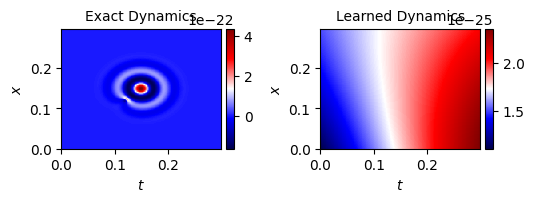

In [10]:
N_u_ic = 1000
N_u_bc =  1000 # Total number of data points for 'u'
N_pde = N_d = 5000 # Total number of PDE collocation points and corresponding data points

# Training data
'''
X_f_train = (x,y,t) of PDE collocation points
f_train = true value at PDE collocation points
X_u_ic_train = (x,y,t=0) of Initial condition points
u_ic_train = true value at Initial condition points
X_u_bc_train = (x,y,t) of Boundary points
u_bc_train = true value at Boundary points
'''
X_pde_train, u_f_train, X_u_ic_train, u_ic_train, X_u_bc_train, u_bc_train = trainingdata(N_u_ic, N_u_bc, N_pde ,N_d)

# network architecture
layers = np.array([5,20, 20, 20, 20,1])

PINN = Parametricmodel(layers)

init_params = PINN.get_weights().numpy()
#print(init_params)

start_time = time.time()

#network = PINN.evaluate(X_f_train)
#Train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun=PINN.optimizerfunc,
                                  x0 = init_params,
                                  args=(),
                                  method='L-BFGS-B',
                                  jac=True,
                                  callback=PINN.optimizer_callback,
                                  options={'disp':None,
                                           'maxcor':200,
                                           'ftol':1*np.finfo(float).eps,
                                           'gtol':5e-8,
                                           'maxfun':50000,
                                           'maxiter':20000, # Maximum number of iterations.
                                           'iprint':-1,
                                           'maxls':50})  # Maximum number of line search  (per iteration). Default is 20.

elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

# Test Data
snap = np.array([8])
x_test = x_star # ((364816, 1)
y_test = y_star # (364816, 1)
t_test = t_star # (364816, 1)
U_test = u_star # (364816, 1)
dx_test = dx_star # (364816, 1)
dy_test = dy_star # (364816, 1)

# Prediction
u_pred = PINN.predict(x_test,y_test,t_test,dx_test,dy_test)

error_u = np.linalg.norm(U_test-u_pred,2)/np.linalg.norm(U_test,2)
print('Error w: %e' % (error_u))

u_pred = np.reshape(u_pred,(-1,16))

#-------------------Plotting-----------------------------------------
snap = 8
lb_plot = X_Y_data.min(0)
ub_plot = X_Y_data.max(0)
nn = 200
x_plot = np.linspace(lb_plot[0], ub_plot[0], nn)
y_plot = np.linspace(lb_plot[1], ub_plot[1], nn)
X_plot, Y_plot = np.meshgrid(x_plot,y_plot)

U_data_plot = griddata(X_Y_data, disp_data[:,snap].flatten(), (X_plot, Y_plot), method='cubic')
U_pred_plot = griddata(X_Y_data, u_pred[:,snap].flatten(), (X_plot, Y_plot), method='cubic')

fig, ax = newfig(1.0, 0.6)
ax.axis('off')

########      Exact     ###########
gs = gridspec.GridSpec(1, 2)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs[:, 0])
h = ax.imshow(U_data_plot, interpolation='nearest', cmap='seismic',
              extent=[lb_plot[0], ub_plot[0], lb_plot[1], ub_plot[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Exact Dynamics', fontsize = 10)


########     Learned     ###########
ax = plt.subplot(gs[:, 1])
h = ax.imshow(U_pred_plot, interpolation='nearest', cmap='seismic',
              extent=[lb_plot[0], ub_plot[0], lb_plot[1], ub_plot[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Learned Dynamics', fontsize = 10)

plt.savefig('wave2d_8.png',dpi = 600)
plt.show()